In [55]:
# library import
import pandas as pd # DataFrame support
import numpy as np # algebra / computations

import matplotlib.pyplot as plt # plotting
import seaborn as sns # fancier plotting
%matplotlib inline

import sklearn
import warnings

import matplotlib
matplotlib.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (8.5, 5)
plt.rcParams["patch.force_edgecolor"] = True
pd.set_option('display.float_format', lambda x: '%.3f' % x)
sns.mpl.rc("figure", figsize=(8.5,5))

In [3]:
df_train = pd.read_csv(filepath_or_buffer='train.csv', 
                       engine='c', 
                       infer_datetime_format=True, # to speed-up datetime parsing
                       parse_dates=[2,3] # specify datetime columns
                      )

df_train.store_and_fwd_flag = df_train.store_and_fwd_flag.astype('category')

In [5]:
# optimize dtypes for memory usage
df_train.passenger_count = df_train.passenger_count.astype(np.uint8)
df_train.vendor_id = df_train.vendor_id.astype(np.uint8)
df_train.trip_duration = df_train.trip_duration.astype(np.uint32)
for c in [c for c in df_train.columns if c.endswith('tude')]:
    df_train.loc[:, c] = df_train[c].astype(np.float32)

In [6]:
df_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [47]:
df_train.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
mm_pickup             0
mm_dropoff            0
dow_pickup            0
dow_dropoff           0
hh_pickup             0
hh_dropoff            0
dtype: int64

#### no N/A values

In [48]:
df_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
vendor_id,1447779.0,1.535046,0.498770,1.000000,1.000000,2.000000,2.000000,2.000000
passenger_count,1447779.0,1.665358,1.314684,1.000000,1.000000,1.000000,2.000000,9.000000
pickup_longitude,1447779.0,-73.973625,0.070765,-121.933342,-73.991875,-73.981766,-73.967430,-61.335529
pickup_latitude,1447779.0,40.750980,0.032670,34.359695,40.737411,40.754135,40.768368,51.881084
dropoff_longitude,1447779.0,-73.973579,0.070504,-121.933304,-73.991325,-73.979767,-73.963097,-61.335529
dropoff_latitude,1447779.0,40.751850,0.035725,32.181141,40.735943,40.754559,40.769829,43.921028
trip_duration,1447779.0,840.874047,653.257941,60.000000,401.000000,665.000000,1076.000000,7191.000000
mm_pickup,1447779.0,3.516460,1.681069,1.000000,2.000000,4.000000,5.000000,6.000000
mm_dropoff,1447779.0,3.516770,1.681240,1.000000,2.000000,4.000000,5.000000,7.000000
dow_pickup,1447779.0,3.049533,1.953777,0.000000,1.000000,3.000000,5.000000,6.000000


In [14]:
# check for duplicate ids - nice, no duplicates
print('No of Duplicates, Trip IDs: {}'.format(len(df_train) - 
                                              len(df_train.drop_duplicates(subset='id'))))

# check latitude/longitude bounds, Latitude: -85 to +85, Longitude: -180 to +180
print('Latitude bounds: {} to {}'.format(
    max(df_train.pickup_latitude.min(), df_train.dropoff_latitude.min()),
    max(df_train.pickup_latitude.max(), df_train.dropoff_latitude.max())
))
print('Longitude bounds: {} to {}'.format(
    max(df_train.pickup_longitude.min(), df_train.dropoff_longitude.min()),
    max(df_train.pickup_longitude.max(), df_train.dropoff_longitude.max())
))

# check trip duration - oops, looks like:
# 1) someone was on the road for 3526282sec ~ 40 days and forget to switch-off the counter, he-he
# 2) someone has invented quantum teleportation and made trips in 1-2 sec
# more closer look reveals some consecutive measurements, say, distance = 33ft, time=1sec
print('Trip duration in seconds: {} to {}'.format(
    df_train.trip_duration.min(), df_train.trip_duration.max()
))
# let's also check that trip_duration == drop-off time - pick-up time, nice, no errors
print("Incorrect trip duration's calculations: {}".format(
    (df_train.trip_duration != df_train.dropoff_datetime.sub(df_train.pickup_datetime, axis=0) 
     / np.timedelta64(1, 's')).sum())
)

# vendors cnt, only 2
print('Vendors cnt: {}'.format(len(df_train.vendor_id.unique())))
# datetime range - 6 full months, from January 2016 to June 2016
print('Datetime range: {} to {}'.format(df_train.pickup_datetime.min(), 
                                        df_train.dropoff_datetime.max()))

# passenger count - the common sense implies values between 1 and 10(Ford Transit), let's check
# zeroes, hmm...
print('Passengers: {} to {}'.format(df_train.passenger_count.min(), 
                                        df_train.passenger_count.max()))

No of Duplicates, Trip IDs: 0
Latitude bounds: 34.35969543457031 to 51.88108444213867
Longitude bounds: -121.93330383300781 to -61.33552932739258
Trip duration in seconds: 1 to 3526282
Incorrect trip duration's calculations: 0
Vendors cnt: 2
Datetime range: 2016-01-01 00:00:17 to 2016-07-01 23:02:03
Passengers: 0 to 9


In [15]:
# Since there are less than 10k rows with anomalies in trip_duration (in common sense), 
# we can safely remove them
duration_mask = ((df_train.trip_duration < 60) | # < 1 min
             (df_train.trip_duration > 3600*2)) # > 2 hours
print('Anomalies in trip duration, %: {:.2f}'.format(
    df_train[duration_mask].shape[0] / df_train.shape[0] * 100
))
df_train = df_train[~duration_mask]
df_train.trip_duration = df_train.trip_duration.astype(np.uint16)
# let's see range now
print('Trip duration in seconds: {} to {}'.format(
    df_train.trip_duration.min(), df_train.trip_duration.max()
))

# let's also drop trips with passenger count = 0, since there are only 17 of them
print('Empty trips: {}'.format(df_train[df_train.passenger_count == 0].shape[0]))
df_train = df_train[df_train.passenger_count > 0]

Anomalies in trip duration, %: 0.74
Trip duration in seconds: 60 to 7191
Empty trips: 17


In [16]:
# Let's add some additional columns to speed-up calculations
# dow names for plot mapping
dow_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# mm names for plot mapping
mm_names = [
    'January', 'February', 'March', 'April', 'May', 'June', 
    'July', 'August', 'September', 'October', 'November', 'December'
]

# month (pickup and dropoff)
df_train['mm_pickup'] = df_train.pickup_datetime.dt.month.astype(np.uint8)
df_train['mm_dropoff'] = df_train.dropoff_datetime.dt.month.astype(np.uint8)
# day of week
df_train['dow_pickup'] = df_train.pickup_datetime.dt.weekday.astype(np.uint8)
df_train['dow_dropoff'] = df_train.dropoff_datetime.dt.weekday.astype(np.uint8)
# day hour
df_train['hh_pickup'] = df_train.pickup_datetime.dt.hour.astype(np.uint8)
df_train['hh_dropoff'] = df_train.dropoff_datetime.dt.hour.astype(np.uint8)

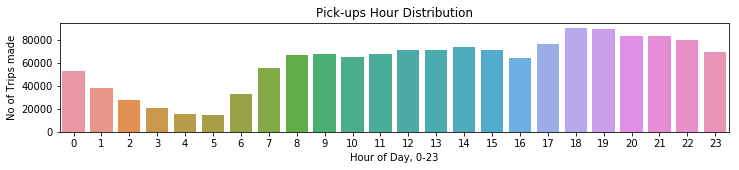

In [18]:
# pickup time distribution, hour-of-day
plt.figure(figsize=(12,2))

data = df_train.groupby('hh_pickup').aggregate({'id':'count'}).reset_index()
sns.barplot(x='hh_pickup', y='id', data=data)

plt.title('Pick-ups Hour Distribution')
plt.xlabel('Hour of Day, 0-23')
plt.ylabel('No of Trips made')
plt.show()

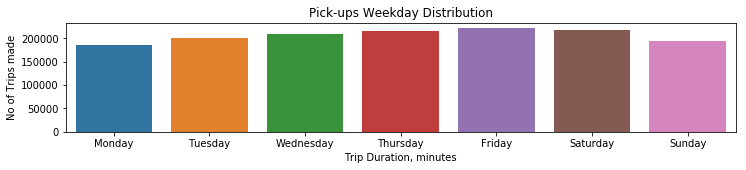

In [19]:
# pickup distribution, by weekday
plt.figure(figsize=(12,2))

data = df_train.groupby('dow_pickup').aggregate({'id':'count'}).reset_index()
sns.barplot(x='dow_pickup', y='id', data=data)

plt.title('Pick-ups Weekday Distribution')
plt.xlabel('Trip Duration, minutes')
plt.xticks(range(0,7), dow_names, rotation='horizontal')
plt.ylabel('No of Trips made')
plt.show()

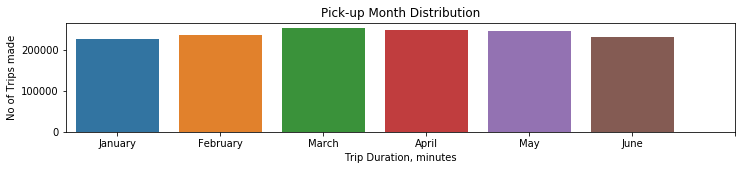

In [22]:
# pickup distribution, by months
plt.figure(figsize=(12,2))

data = df_train.groupby('mm_pickup').aggregate({'id':'count'}).reset_index()
sns.barplot(x='mm_pickup', y='id', data=data)

plt.title('Pick-up Month Distribution')
plt.xlabel('Trip Duration, minutes')
plt.xticks(range(0,7), mm_names[:6], rotation='horizontal')
plt.ylabel('No of Trips made')
plt.show()

In [ ]:
pd.crosstab

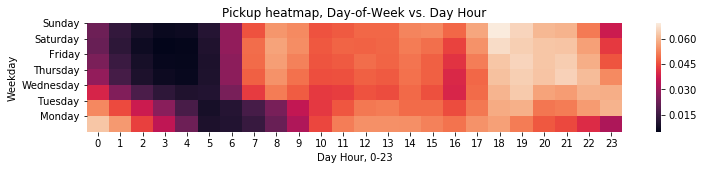

In [42]:
# Pickup heatmap, dow vs hour
plt.figure(figsize=(12,2))
sns.heatmap(data=pd.crosstab(df_train.dow_pickup, 
                             df_train.hh_pickup, 
                             values=df_train.vendor_id, 
                             aggfunc='count',
                             normalize='index'))

plt.title('Pickup heatmap, Day-of-Week vs. Day Hour')
plt.ylabel('Weekday') ; plt.xlabel('Day Hour, 0-23')
plt.yticks(range(0,7), dow_names[::-1], rotation='horizontal')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


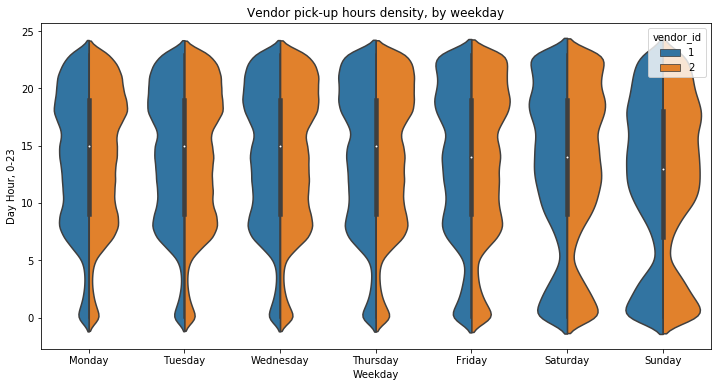

In [43]:
# vendor pick-up hours density by weekdays
plt.figure(figsize=(12,6))
sns.violinplot(x=df_train.dow_pickup, 
               y=df_train.hh_pickup, 
               hue=df_train.vendor_id, 
               split=True)

plt.title('Vendor pick-up hours density, by weekday')
plt.xlabel('Weekday') ; plt.ylabel('Day Hour, 0-23')
plt.xticks(range(0,7), dow_names, rotation='horizontal')
plt.show()

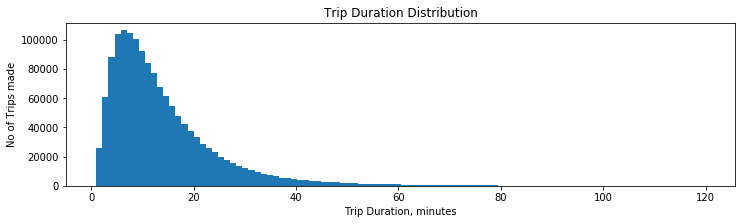

In [44]:
# trip duration distribution, minutes
plt.figure(figsize=(12,3))
plt.title('Trip Duration Distribution')
plt.xlabel('Trip Duration, minutes')
plt.ylabel('No of Trips made')
plt.hist(df_train.trip_duration/60, bins=100)
pass

In [67]:
train_data = pd.read_csv(filepath_or_buffer='train.csv', 
                       engine='c', 
                       infer_datetime_format=True, # to speed-up datetime parsing
                       parse_dates=[2,3] # specify datetime columns
                      )

# Delimit pickup_datetime variable 
train_data['pickup_date'] = train_data['pickup_datetime'].dt.date # Extract date
train_data['pickup_time'] = train_data['pickup_datetime'].dt.time # Extract time

# Delimit dropoff_datetime variables
train_data['dropoff_date'] = train_data['dropoff_datetime'].dt.date # Extract date
train_data['dropoff_time'] = train_data['dropoff_datetime'].dt.time # Extract time

# Additional pickup features
train_data['pickup_month'] = train_data['pickup_datetime'].dt.month # Extract month
# train_data['pickup_month'] = train_data.pickup_datetime.dt.to_period('M') # Extract yearmonth
#train_data['pickup_YYYYMM'] = train_data['pickup_datetime'].apply(lambda x: x.strftime('%Y%m')) # Extract yearmonth
train_data['pickup_hour'] = train_data['pickup_datetime'].dt.hour # Extract hour
train_data['pickup_weekday'] = train_data['pickup_datetime'].dt.dayofweek # Extract day of week

# Drop concatentated timestamp columns
train_data.drop(['pickup_datetime'], axis = 1, inplace = True)
train_data.drop(['dropoff_datetime'], axis = 1, inplace = True)

# Confirm changes
train_data.columns

Index(['id', 'vendor_id', 'passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'store_and_fwd_flag', 'trip_duration', 'pickup_date', 'pickup_time',
       'dropoff_date', 'dropoff_time', 'pickup_month', 'pickup_hour',
       'pickup_weekday'],
      dtype='object')

In [69]:
duration_mask = ((train_data.trip_duration < 60) | # < 1 min
             (train_data.trip_duration > 3600*2)) # > 2 hours
train_data = train_data[~duration_mask]
train_data.trip_duration = train_data.trip_duration.astype(np.uint16)
train_data = train_data[train_data.passenger_count > 0]

In [61]:
train_data.describe()[['trip_duration']].transpose()

,count,mean,std,min,25%,50%,75%,max
trip_duration,1447779.000,840.874,653.258,60.000,401.000,665.000,1076.000,7191.000


In [72]:
# Remove unnecessary features
train_data.drop(['pickup_date','pickup_time','dropoff_date', 'dropoff_time','id'], 
                axis = 1, inplace = True)

In [75]:
train_data.columns

Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_month', 'pickup_hour', 'pickup_weekday'],
      dtype='object')

In [77]:
train_data.dtypes

vendor_id               int64
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration          uint16
pickup_month            int64
pickup_hour             int64
pickup_weekday          int64
dtype: object

In [80]:
# Encode categorical variables
train_data['store_and_fwd_flag'] = train_data['store_and_fwd_flag'].map({'N':0,'Y':1})

In [81]:
# Split
# Create matrix of features
X = train_data[['vendor_id', 'passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'store_and_fwd_flag','pickup_month', 'pickup_hour',
       'pickup_weekday']] # double brackets!

# Create array of target variable 
y = train_data['trip_duration']

# Create train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

### Linear Regression

In [82]:
#  Import model
from sklearn.linear_model import LinearRegression

#  Instantiate model object
lreg = LinearRegression()

# Fit to training data
lreg.fit(X_train,y_train)
print(lreg)

# Predict
y_pred_lreg = lreg.predict(X_test)

# Score It
from sklearn import metrics
print('\nLinear Regression Performance Metrics')
print('R^2=',metrics.explained_variance_score(y_test,y_pred_lreg))
print('MAE:',metrics.mean_absolute_error(y_test,y_pred_lreg))
print('MSE:',metrics.mean_squared_error(y_test,y_pred_lreg))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test,y_pred_lreg)))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

Linear Regression Performance Metrics
R^2= 0.10400252210475147
MAE: 442.3307525350176
MSE: 381373.55199655116
RMSE: 617.5544931393109


#### Such a low score is an indication that the relationship between the features and independent variable may be better explained with a non-linear model.

### Decision Tree

In [87]:
# Fit
# Import model
from sklearn.tree import DecisionTreeRegressor

# Instantiate model object
dtree = DecisionTreeRegressor()

# Fit to training data
dtree.fit(X_train,y_train)
print(dtree)

# Predict
y_pred_dtree = dtree.predict(X_test)

# Score It
from sklearn import metrics
print('\nDecision Tree Regression Performance Metrics')
print('R^2=',metrics.explained_variance_score(y_test,y_pred_dtree))
print('MAE:',metrics.mean_absolute_error(y_test,y_pred_dtree))
print('MSE:',metrics.mean_squared_error(y_test,y_pred_dtree))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test,y_pred_dtree)))

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

Decision Tree Regression Performance Metrics
R^2= 0.5908669616869409
MAE: 260.38859322549007
MSE: 174229.3237137203
RMSE: 417.40786254420306


### Random Forest

In [88]:
# Fit 
# Import model
from sklearn.ensemble import RandomForestRegressor 

# Instantiate model object
rforest = RandomForestRegressor(n_estimators = 20, n_jobs = -1)

# Fit to training data
rforest = rforest.fit(X_train,y_train)
print(rforest)

# Predict
y_pred_rforest = rforest.predict(X_test)

# Score It
from sklearn import metrics
print('\nRandom Forest Regression Performance Metrics')
print('R^2 =',metrics.explained_variance_score(y_test,y_pred_rforest))
print('MAE',metrics.mean_absolute_error(y_test, y_pred_rforest))
print('MSE',metrics.mean_squared_error(y_test, y_pred_rforest))
print('RMSE',np.sqrt(metrics.mean_squared_error(y_test, y_pred_rforest)))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

Random Forest Regression Performance Metrics
R^2 = 0.7955100049906885
MAE 187.33461079779613
MSE 87134.31404123179
RMSE 295.18521988953273
